## InfluxDB 연결 설정
InfluxDB 연결 정보 설정 및 장비 맵핑

In [3]:
%pip install influxdb_client

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import pytz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# InfluxDB 설정 정보
url = "http://133.186.144.22:8086"
token = "r3Ecro-rJQ82UpyNScnHXYDZ3KaE45AzweCXz6QIv2jeo7eOP4hL4-A9uKvkAVQDg_xavWorGUGZn7MI_sPCwg=="
org = "smoothing"

# Device ID와 위치를 매핑
location_mapping = {
    '24e124126d152919': 'indoor',
    '24e124126d152969': 'bottom_right_corner',
    '24e124128c067999': 'indoor',
    '24e124785c389818': 'bottom_left_corner',
    '24e124785c421885': 'top_right_corner'
}

Start time in UTC: 2024-05-04 15:00:00+00:00
End time in UTC: 2024-05-05 15:00:00+00:00


### 시간대 설정
InfluxDB의 조회 시간이 국제 표준시 UTC로 되어 있기 때문에 한국 표준시로 변경을 해야한다.

따라서 아래 내용에 맞게 한국 표준시로 설정하였다.

In [14]:
# 한국 시간대 설정
korea_tz = pytz.timezone('Asia/Seoul')

# 실행 시점의 날짜를 기준으로 전날의 날짜를 계산
today_kst = datetime.now(korea_tz)
yesterday_kst = today_kst - timedelta(days=1)

# 전날의 시작과 끝 시간을 한국 시간대로 설정
start_time_kst = korea_tz.localize(datetime(yesterday_kst.year, yesterday_kst.month, yesterday_kst.day, 0, 0, 0))
end_time_kst = start_time_kst + timedelta(days=1)

# UTC로 시간 변환
start_time_utc = start_time_kst.astimezone(pytz.utc)
end_time_utc = end_time_kst.astimezone(pytz.utc)

# 확인을 위해 출력
print("Start time in UTC:", start_time_utc)
print("End time in UTC:", end_time_utc)

Start time in UTC: 2024-05-05 15:00:00+00:00
End time in UTC: 2024-05-06 15:00:00+00:00



### 함수 기능
기능 구현에 따른 함수를 사용하기 위한 내용을 아래에 작성하였다.

(구현이 완료되면 구현 마다 각 함수 내용 작성)

In [38]:
def create_client(url, token, org):
    """
    Influx DB 연결 Client를 생성합니다.
    
    :param url: InfluxDB 연결 주소
    :param token: InfluxDB 토큰
    :param org:  InfluxDB 조직
    :return: InfluxDBClient
    """
    return InfluxDBClient(url=url, token=token, org=org)

def query_to_dataframe(client, query, field = "location"):
    """
    구성된 쿼리를 실행하고 전달받은 데이터를 Dataframe으로 만듭니다.
    
    :param field: 기본값 location
    :param client: InfluxDBClient
    :param query: 요청할 쿼리
    :return: DataFrame 
    """
    result = client.query_api().query(query=query)
    results = []
    
    for table in result:
        for record in table.records:
            results.append({
                "time": record.get_time(),
                "value": record.get_value(),
                "place": record.values.get("place"),
                "location": record.values.get(field),
                "device": record.values.get("device")
            })
    
    df = pd.DataFrame(results)
    df['time'] = df['time'].astype(str).str.replace(r'\+00:00$', '', regex=True)
    return df

def save_csv(df, file_pattern, directory):
    
    """
    DataFrame을 CSV로 변환하여 저장합니다.
    
    :param df: DataFrame
    :param file_pattern: 파일 이름 패턴
    :param directory: 저장할 위치
    """
    # 파일 경로를 확인 하고 없다면 생성 합니다.
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    previous_date = datetime.now() - timedelta(days=1)
    filename = f"{directory}{previous_date.strftime(file_pattern)}"
    df.to_csv(filename, index=False)
        
def update_location(df):
    """
    환경 센서 Data에서 Device ID를 확인 하여 'location' 열을 업데이트 합니다.
    
    :param df: 환경 센서 DataFrame
    :return: 'location' 열을 업데이트한 DataFrame
    """
    df['location'] = df['device'].map(location_mapping)
    return df

def merge_data(directory_path):
    """
    CSV 파일들을 하나의 DataFrame으로 병합하고 정렬 합니다.
    
    :param directory_path: 파일 경로 
    :return: 병합된 DataFrame
    """
    # 파일 내의 모든 CSV 파일 목록을 생성
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 모든 CSV 파일을 DataFrame으로 읽어와 하나로 병합
    data_frames = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'])
        data_frames.append(df)

    merged_df = pd.concat(data_frames, ignore_index=True)

    # 로그 스케일 적용 (값이 0 이상일 경우만 로그를 취함)
    merged_df['value'] = merged_df['value'].apply(lambda x: np.log(x) if x > 0 else x)

    # 해당 컬럼들로 재구성
    columns_to_keep = ['time', 'value', 'place', 'location']
    filtered_df = merged_df[columns_to_keep]

    # 'place', 'time' 으로 정렬
    sorted_df = filtered_df.sort_values(['place', 'time'])

    return sorted_df

def df_hourly_calculate(dataframe, change_column_name, calculate):
    """
    DataFrame에서 value를 시간별로 calculate 함수에 따라 계산합니다.
    계산 후 value 컬럼을 지정한 이름으로 변경합니다.
        
    :param dataframe: 계산할 DataFrame
    :param change_column_name: 계산 후 value 컬럼을 지정한 이름으로 변경
    :param calculate: 문자열 형태로 계산할 함수명 ('sum', 'mean', 'diff' 등)
    :return: 시간별 계산된 DataFrame
    """
    # 시간 컬럼이 datetime형태인지 확인하고 설정후 Index로 설정
    if not pd.api.types.is_datetime64_any_dtype(dataframe.index):
        dataframe['time'] = pd.to_datetime(dataframe['time'])
        dataframe.set_index('time', inplace=True)

    # 시간별로 그룹화하여 데이터 계산
    if calculate == 'diff':
        # 시간별로 데이터 변화량 계산
        result = dataframe['value'].resample('H').last().diff().rename(change_column_name)
    else:
        # 기타 계산
        result = dataframe.resample('H').agg({'value': calculate}).rename(columns={'value': change_column_name})

    # Null 값 채우기 (forward fill)
    result.fillna(method='bfill', inplace=True)

    # 결과를 소수점 세 자리까지 반올림
    result = result.round(3)

    return result

def merge_dataframes(df_list):
    """
    여러 DataFrame을 병합합니다. 
    
    :param df_list: 병합할 DataFrame 리스트
    :return: 병합된 DataFrame
    """
    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer', validate=None)
    return merged_df

def calculate_attendance(dataframe):
    # time 컬럼을 datetime 타입으로 변환
    dataframe['time'] = pd.to_datetime(dataframe['time'])

    # 시간대별로 그룹화 (시간, 분, 초까지 모두 고려)
    grouped = dataframe.groupby(['time', 'location'])['value'].sum().unstack().fillna(0)

    # 입장과 퇴장 데이터 분리
    grouped['in'] = grouped.filter(like='_in').sum(axis=1)
    grouped['out'] = grouped.filter(like='_out').sum(axis=1)

    # 순 입장 인원 계산 (재실 인원)
    grouped['net'] = grouped['in'] - grouped['out']

    # 누적 재실 인원 계산
    cumulative = 0  # 초기값 설정
    cumulative_results = []  # 누적 결과를 저장할 리스트
    for net in grouped['net']:
        cumulative += net
        if cumulative < 0:
            cumulative = 0  # 음수는 0으로 처리
        cumulative_results.append(cumulative)

    grouped['cumulative'] = cumulative_results

    return grouped[['cumulative']]

def separation_dataframe(dataframe):
    
    # 'location' 별로 데이터 프레임 그룹화
    grouped = dataframe.groupby('location')

    # 딕셔너리에 데이터 프레임 저장
    dataframes = {location.replace(" ", "_").lower(): df for location, df in grouped}

    return dataframes

def plot(data, title):
    """
    데이터에 대해 plot을 그리는 함수
    
    :param title: plot의 제목
    :param data: 데이터 프레임
    """
    # 데이터의 통계 요약 출력
    print(data.describe())

    # 전체 그래프 창 설정
    plt.figure(figsize=(20, 6))

    # 첫 번째 그래프 (displot)
    plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 위치
    sns.histplot(data['value'], kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('빈도')

    # 두 번째 그래프 (박스 플롯)
    plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
    sns.boxplot(data=data, x='place', y='value')
    plt.title(title)
    plt.xlabel('Place')
    plt.ylabel('Value')

    plt.tight_layout()  # 레이아웃 자동 조정
    plt.show()

def detect_outliers_isolation_forest(df):
    # 모델 생성 및 학습
    iso_forest = IsolationForest(n_estimators=100, contamination='auto')
    preds = iso_forest.fit_predict(df[['value']])

    # 이상치를 -1로 표시, 정상 데이터를 1로 표시
    df['outlier'] = preds
    filtered_df = df[df['outlier'] == 1].drop('outlier', axis=1)

    return filtered_df

### 쿼리를 통한 데이터 수집
InfluxDB에 연결하여 해당 쿼리들을 통해 아래 내용의 데이터를 수집한다.

전력(W), 전력 사용량(Kwh), 온도, CO2, 조도, 습도, 이동 감지 카운터

In [34]:
# DB 연결 및 쿼리 실행
client = create_client(url, token, org)

# 전력(W) 조회(class a : main) Flux 쿼리
query_power_total_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["location"] == "main")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회(class a : main) Flux 쿼리
query_power_usage_total_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["description"] == "sum")
  |> filter(fn: (r) => r["location"] == "main")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력(W) 조회(class a : main) Flux 쿼리
query_power_device_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["location"] != "main" and r["location"] != "outdoor_unit_room_light")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회(class a : main) Flux 쿼리
query_power_usage_device_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["description"] == "sum")
  |> filter(fn: (r) => r["location"] != "main" and r["location"] != "outdoor_unit_room_light")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력(W) 조회 (class a : 콘센트)
query_power_socket_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "office")
  |> filter(fn: (r) => r["location"] == "class_a_floor_heating_1" or r["location"] == "class_a_floor_heating_2")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회 (class a : 콘센트)
query_power_usage_socket_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "office")
  |> filter(fn: (r) => r["location"] == "class_a_floor_heating_1" or r["location"] == "class_a_floor_heating_2")
  |> filter(fn: (r) => r["description"] == "sum")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 온도 조회 Flux 쿼리
query_temperature_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["measurement"] == "temperature")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 이산화탄소 조회 Flux 쿼리
query_co2_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "co2")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 조도 조회 Flux 쿼리
query_illumination_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "illumination")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 습도 조회 Flux 쿼리
query_humidity_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "humidity")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 이동 감지 카운터 조회 Flux 쿼리
query_counter_data = f'''
import "experimental"
from(bucket: "milesight")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["_field"] == "line_periodic_data_1_out" or r["_field"] == "line_periodic_data_1_in")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "_field", "device"])
'''

# 전력 CSV 생성(main)
df_power = query_to_dataframe(client, query_power_total_data)
print(df_power.head(2))
save_csv(df_power, "%m_%d_power_total_data.csv", "all_data/power/total/")

# 전력 사용량 CSV 생성(main)
df_power_usage = query_to_dataframe(client, query_power_usage_total_data)
save_csv(df_power_usage, "%m_%d_power_usage_total_data.csv", "all_data/power_usage/total/")
print(df_power_usage.head(2))

# 전력 CSV 생성(device)
df_power_device = query_to_dataframe(client, query_power_device_data)
print(df_power_device.head(2))
save_csv(df_power_device, "%m_%d_power_device_data.csv", "all_data/power/device/")

# 전력 사용량 CSV 생성(device)
df_power_usage_device = query_to_dataframe(client, query_power_usage_device_data)
save_csv(df_power_usage_device, "%m_%d_power_usage_device_data.csv", "all_data/power_usage/device/")
print(df_power_usage_device.head(2))

# 전력 CSV 생성(콘센트)
df_power_socket = query_to_dataframe(client, query_power_socket_data)
print(df_power_socket.head(2))
save_csv(df_power_socket, "%m_%d_power_socket_data.csv", "all_data/power/socket/")

# 전력 사용량 CSV 생성(콘센트)
df_power_usage_socket = query_to_dataframe(client, query_power_usage_socket_data)
print(df_power_usage_socket.head(2))
save_csv(df_power_usage_socket, "%m_%d_power_usage_socket_data.csv", "all_data/power_usage/socket/")

# 온도 CSV 생성
df_temperature = query_to_dataframe(client, query_temperature_data)
df_temperature_fix = update_location(df_temperature)
print(df_temperature_fix.head(2))
save_csv(df_temperature_fix, "%m_%d_temperature_data.csv", "all_data/temperature/")

# co2 CSV 생성
df_co2 = query_to_dataframe(client, query_co2_data)
df_co2_fix = update_location(df_co2)
print(df_co2_fix.head(2))
save_csv(df_co2_fix, "%m_%d_co2_data.csv", "all_data/co2/")

# 조도 CSV 생성
df_illumination = query_to_dataframe(client, query_illumination_data)
update_location(df_illumination)
print(df_illumination.head(2))
save_csv(df_illumination, "%m_%d_illumination_data.csv", "all_data/illumination/")

# 습도 CSV 생성
df_humidity = query_to_dataframe(client, query_humidity_data)
update_location(df_humidity)
print(df_humidity.head(2))
save_csv(df_humidity, "%m_%d_humidity_data.csv", "all_data/humidity/")

# 이동 감지 카운터 CSV 생성
df_counter = query_to_dataframe(client, query_counter_data, "_field")
print(df_counter.head(2))
save_csv(df_counter, "%m_%d_counter_data.csv", "all_data/counter/total/")

# 연결 Client 종료
client.close()

                  time   value    place location     device
0  2024-05-05 00:01:00  1736.0  class_a     main  gems-3500
1  2024-05-05 00:02:00  1815.0  class_a     main  gems-3500
                  time  value    place location     device
0  2024-05-05 00:01:00  856.4  class_a     main  gems-3500
1  2024-05-05 00:02:00  856.5  class_a     main  gems-3500
                  time  value    place        location     device
0  2024-05-05 00:01:00   67.0  class_a  ac_indoor_unit  gems-3500
1  2024-05-05 00:02:00   67.0  class_a  ac_indoor_unit  gems-3500
                  time  value    place        location     device
0  2024-05-05 00:01:00   44.5  class_a  ac_indoor_unit  gems-3500
1  2024-05-05 00:02:00   44.5  class_a  ac_indoor_unit  gems-3500
                  time  value   place                 location     device
0  2024-05-05 00:01:00   28.0  office  class_a_floor_heating_1  gems-3500
1  2024-05-05 00:02:00   28.0  office  class_a_floor_heating_1  gems-3500
                  time  v

### CSV 병합
파일 경로를 통해 집계된 CSV를 병합하고 각각의 Dataframe으로 만든다.

In [39]:
power_path = 'all_data/power/total'
power_total_df = merge_data(power_path)
print(power_total_df.head(2), "\n")

power_usage_path = 'all_data/power_usage/total'
power_usage_total_df = merge_data(power_usage_path)
print(power_usage_total_df.head(2), "\n")

power_device_path = 'all_data/power/device'
power_device_df = merge_data(power_device_path)
print(power_device_df.head(2), "\n")
power_dataframes = separation_dataframe(power_device_df)

power_usage_device_path = 'all_data/power_usage/device'
power_usage_device_df = merge_data(power_usage_device_path)
print(power_usage_device_df.head(2), "\n")
power_usage_dataframes = separation_dataframe(power_usage_device_df)

power_socket_path = 'all_data/power/socket'
power_socket_df = merge_data(power_socket_path)
power_socket_df = power_socket_df.groupby(['time', 'place'])['value'].mean().reset_index()
print(power_socket_df.head(2), "\n")

power_usage_socket_path = 'all_data/power_usage/socket'
power_usage_socket_df = merge_data(power_usage_socket_path)
power_usage_socket_df = power_usage_socket_df.groupby(['time', 'place'])['value'].mean().reset_index()
print(power_usage_socket_df.head(2), "\n")

temperature_path = 'all_data/temperature'
temperature_total_df = merge_data(temperature_path)
print(temperature_total_df.head(2), "\n")

co2_path = 'all_data/co2'
co2_total_df = merge_data(co2_path)
print(co2_total_df.head(2), "\n")

illumination_path = 'all_data/illumination'
illumination_total_df = merge_data(illumination_path)
print(illumination_total_df.head(2), "\n")

humidity_path = 'all_data/humidity'
humidity_total_df = merge_data(humidity_path)
print(humidity_total_df.head(2), "\n")

counter_path = 'all_data/counter/total'
counter_total_df = merge_data(counter_path)
print(counter_total_df.head(2), "\n")

                     time     value    place location
22983 2024-04-15 00:01:00  5.030438  class_a     main
22984 2024-04-15 00:02:00  5.017280  class_a     main 

                     time     value    place location
15753 2024-04-15 00:01:00  5.578597  class_a     main
15754 2024-04-15 00:02:00  5.578597  class_a     main 

                     time     value    place         location
47431 2024-04-15 00:01:00  3.135494  class_a   ac_indoor_unit
48867 2024-04-15 00:01:00  4.762174  class_a  ac_outdoor_unit 

                     time     value    place         location
17253 2024-04-15 00:01:00  2.778819  class_a   ac_indoor_unit
18678 2024-04-15 00:01:00  5.459586  class_a  ac_outdoor_unit 

                 time   place     value
0 2024-04-15 00:01:00  office  3.151309
1 2024-04-15 00:02:00  office  3.138322 

                 time   place    value
0 2024-04-15 00:01:00  office  4.30786
1 2024-04-15 00:02:00  office  4.30786 

                    time     value    place            

### 이상치 확인
Displot과 Boxplot을 사용하여 이상치를 확인한다.

             value
count  1565.000000
mean      3.161870
std       0.037789
min       3.032351
25%       3.137530
50%       3.162963
75%       3.189194
max       3.247766


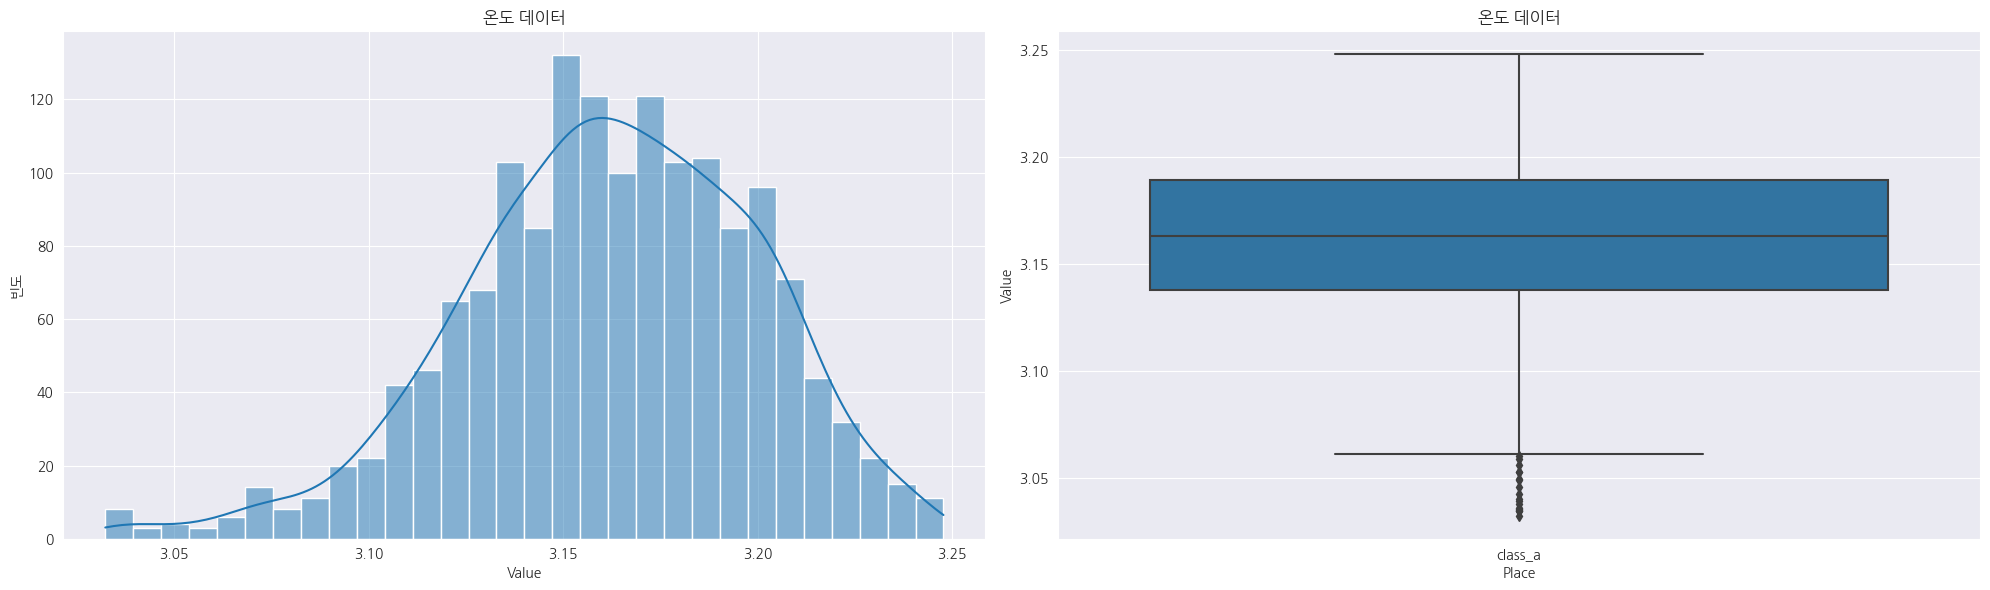

             value
count  1565.000000
mean      3.842991
std       0.123217
min       3.481929
25%       3.755657
50%       3.857930
75%       3.932420
max       4.116493


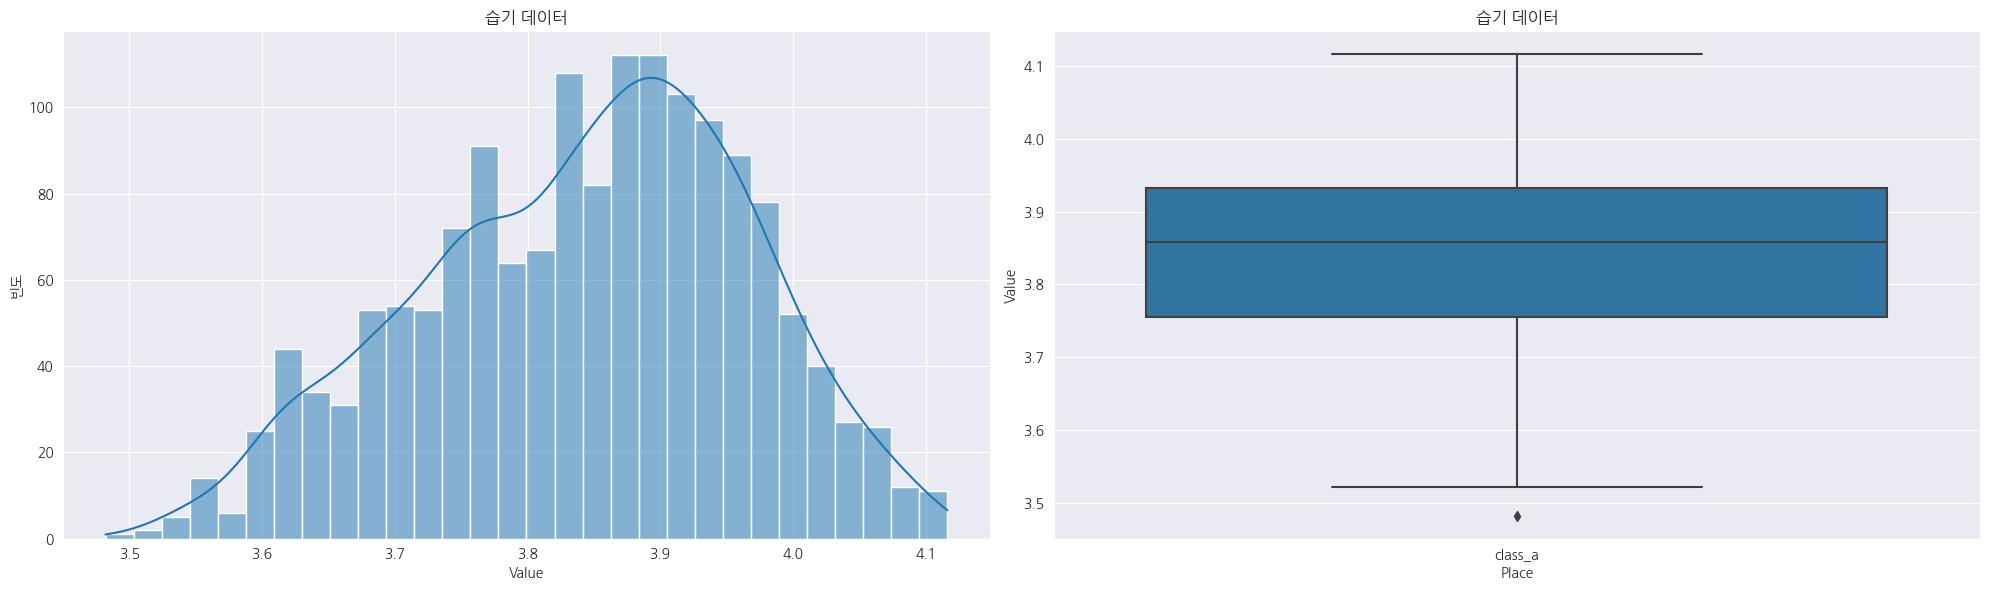

            value
count  504.000000
mean     6.586108
std      0.352061
min      6.209348
25%      6.299190
50%      6.468186
75%      6.779630
max      7.733312


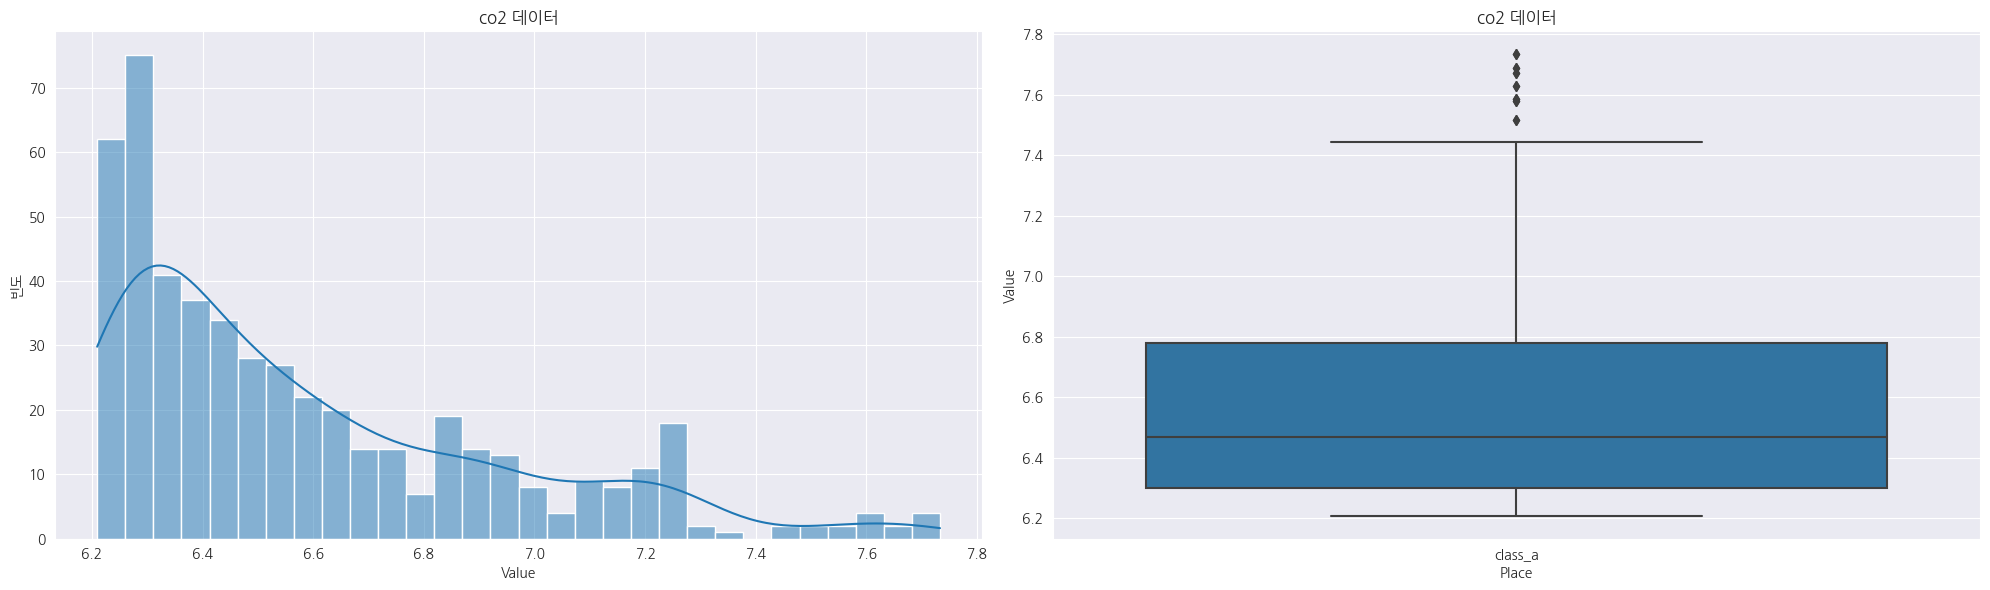

            value
count  505.000000
mean     2.748973
std      1.966865
min     -3.624341
25%      0.000000
50%      4.174900
75%      4.203314
max      4.261444


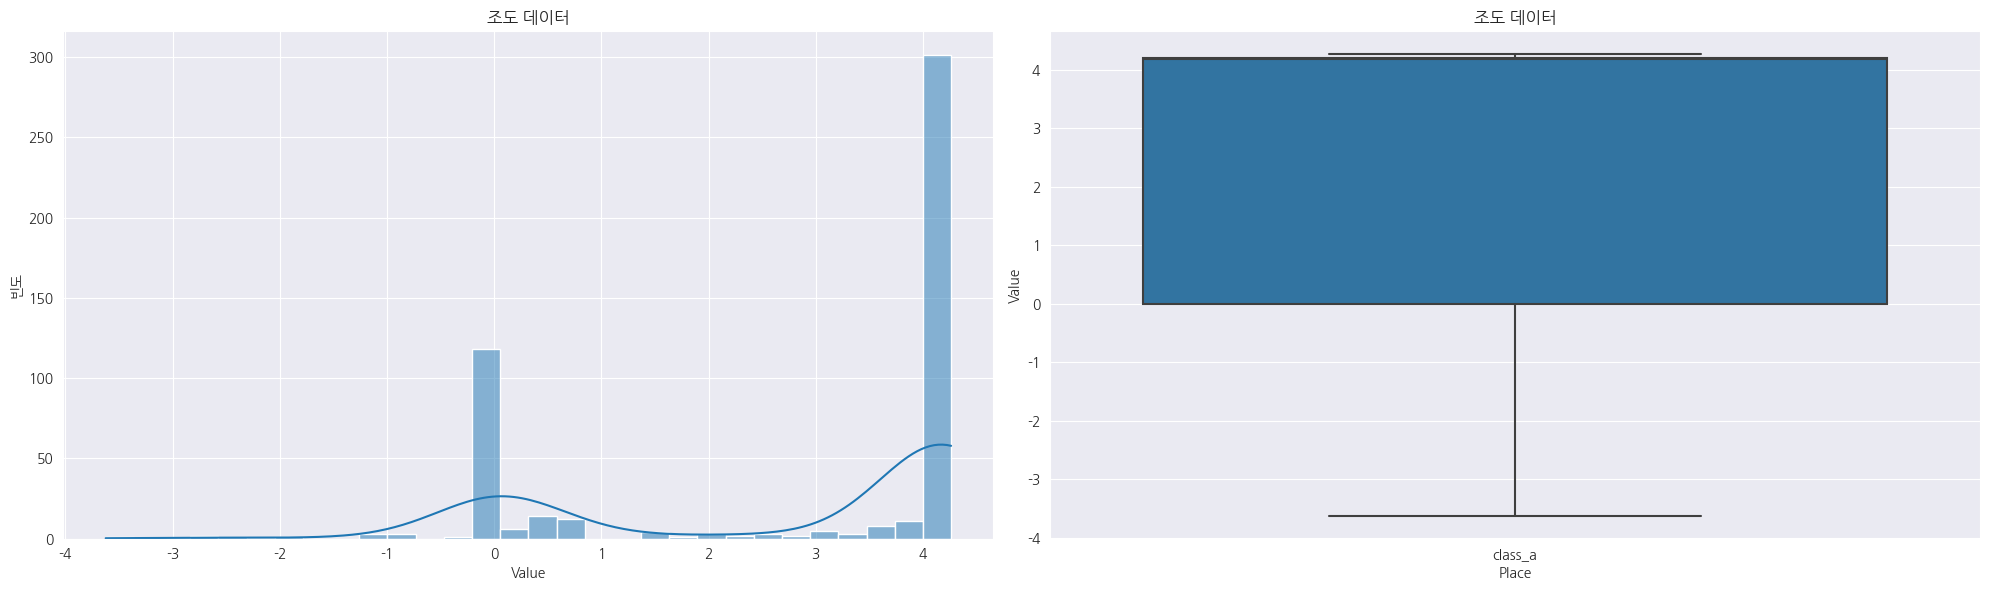

             value
count  1006.000000
mean      1.575291
std       1.634640
min       0.000000
25%       0.000000
50%       1.098612
75%       3.295837
max       4.330733


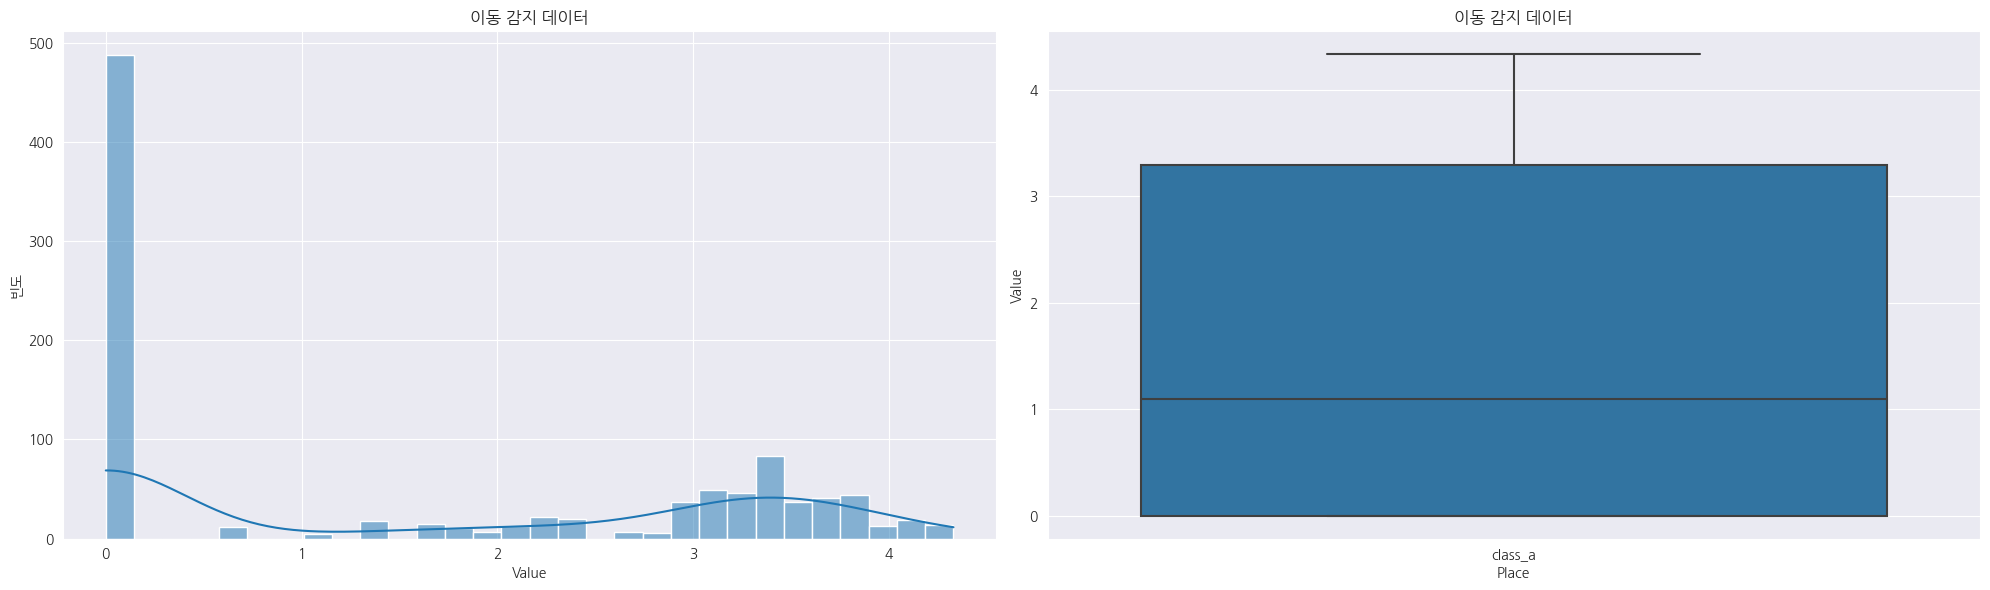

In [40]:
plot(temperature_total_df, "온도 데이터")
plot(humidity_total_df, "습기 데이터")
plot(co2_total_df, "co2 데이터")
plot(illumination_total_df, "조도 데이터")
plot(counter_total_df, "이동 감지 데이터")

### 이상치 제거
확인된 이상치를 Isolation Forest를 사용하여 제거한다.

이상치를 제거후 Dispolt과 Boxplot을 사용하여 다시 확인한다.

             value
count  1202.000000
mean      3.165627
std       0.023665
min       3.119770
25%       3.147650
50%       3.164731
75%       3.184674
max       3.208383


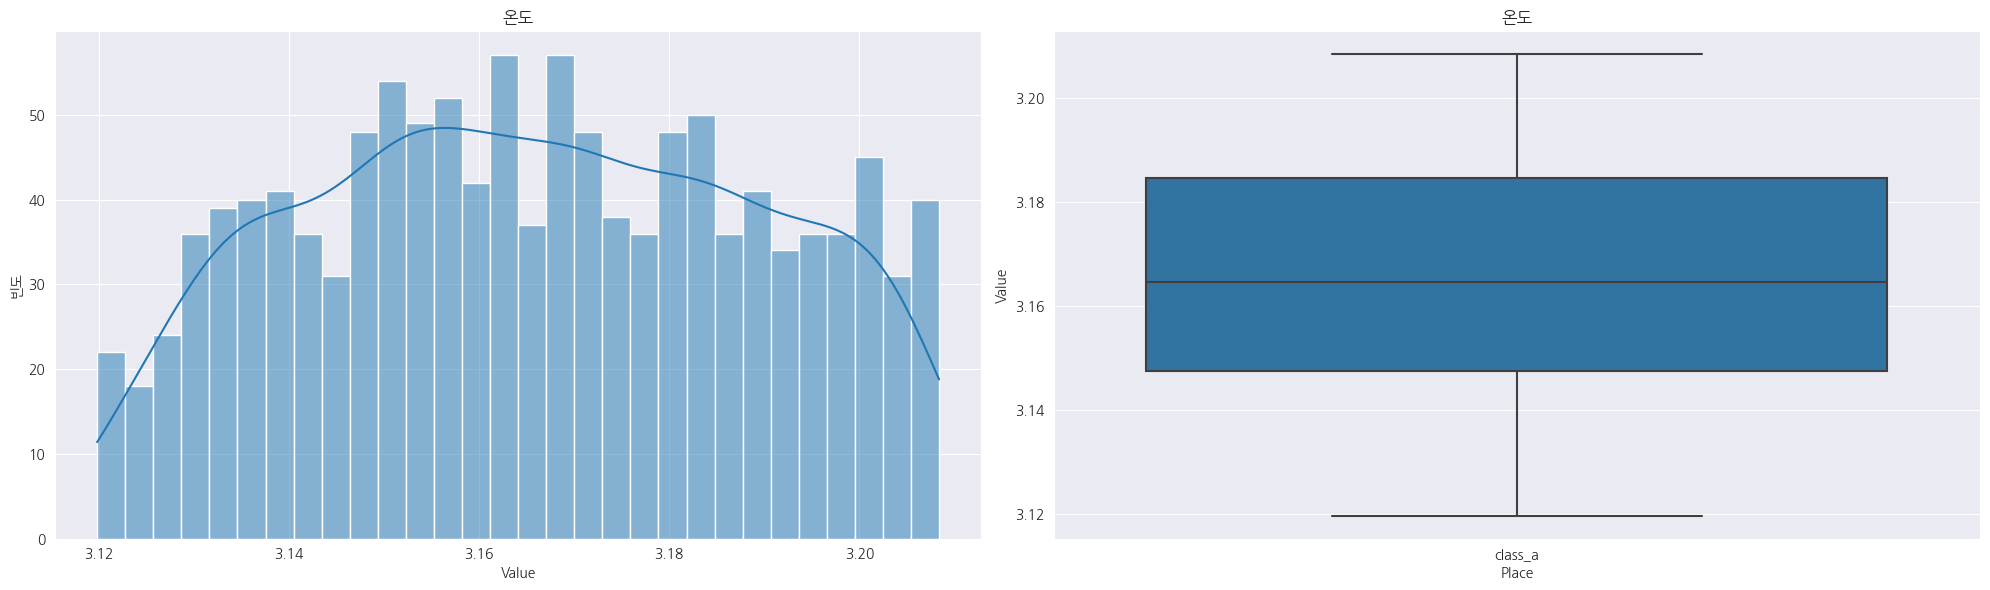

             value
count  1061.000000
mean      3.860206
std       0.069244
min       3.726878
25%       3.805845
50%       3.869668
75%       3.917534
max       3.977928


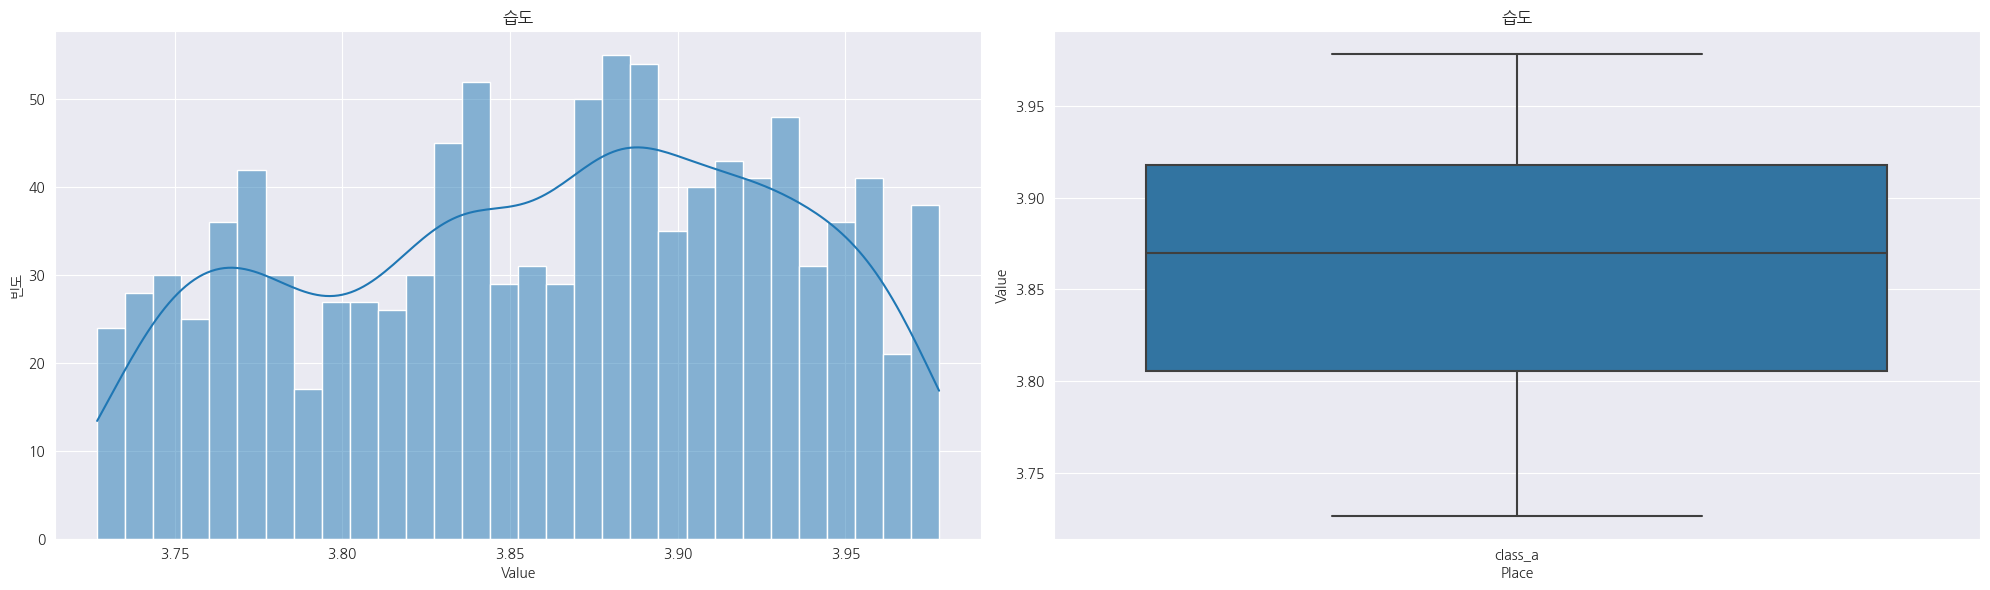

            value
count  358.000000
mean     6.429500
std      0.180355
min      6.229284
25%      6.281631
50%      6.381985
75%      6.524191
max      6.949315


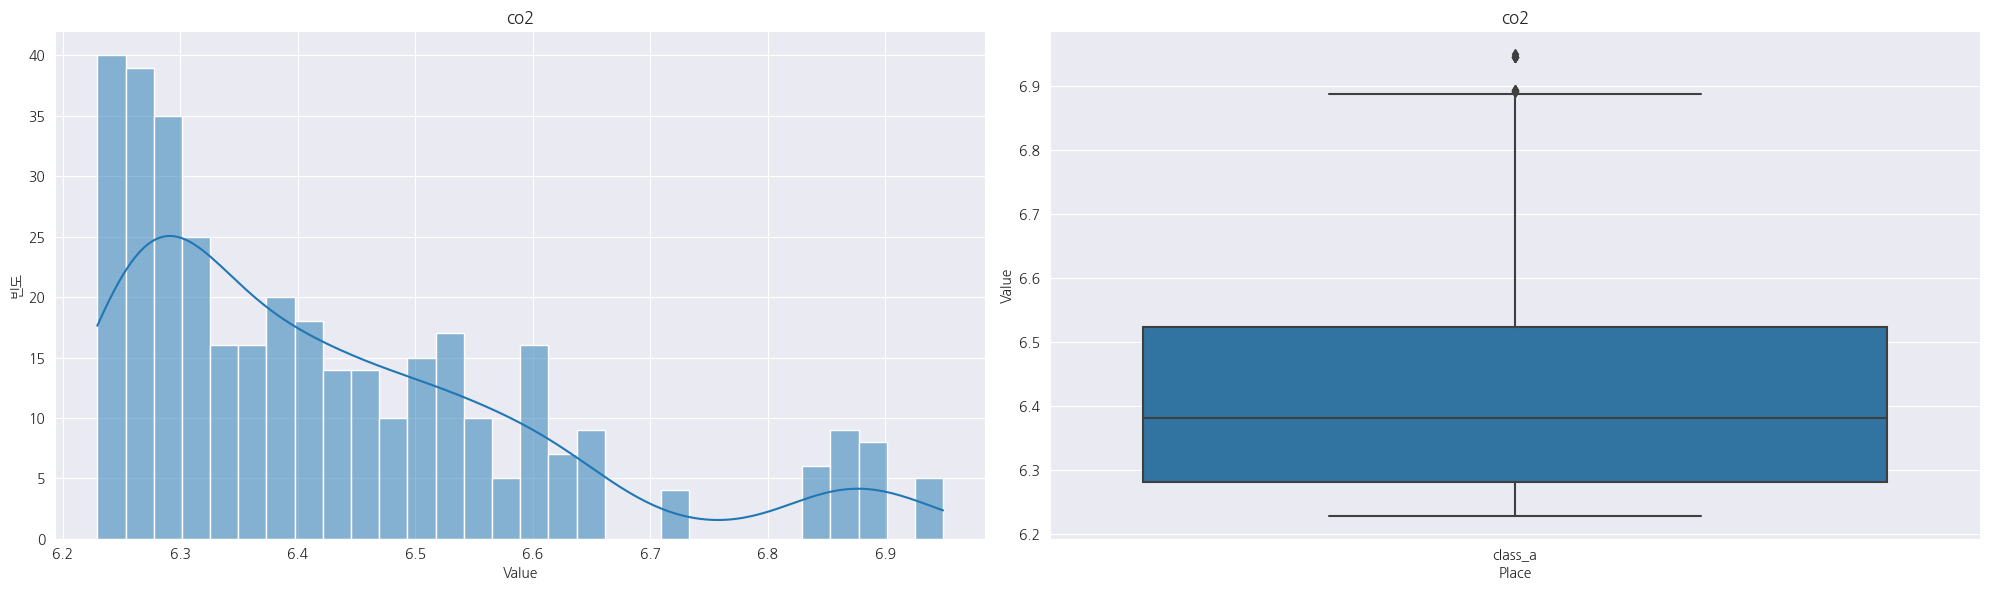

In [41]:
temperature_total_df = detect_outliers_isolation_forest(temperature_total_df)
co2_total_df = detect_outliers_isolation_forest(co2_total_df)
humidity_total_df = detect_outliers_isolation_forest(humidity_total_df)
plot(temperature_total_df, "온도")
plot(humidity_total_df, "습도")
plot(co2_total_df, "co2")

데이터 집계 

In [42]:
temperature_total_df = df_hourly_calculate(temperature_total_df, "average_temperature(°C)", "mean")
humidity_total_df = df_hourly_calculate(humidity_total_df, "average_humidity(%)", "mean")
co2_total_df = df_hourly_calculate(co2_total_df, "average_co2(ppm)", "mean")
illumination_total_df = df_hourly_calculate(illumination_total_df, "average_illumination(lux)", "mean")
counter_total_df = calculate_attendance(counter_total_df)

데이터 병합 (csv)

In [43]:
# 데이터프레임 병합
final_environment_data_df = merge_dataframes([counter_total_df, temperature_total_df, humidity_total_df, co2_total_df, illumination_total_df])

# 결과 확인
print(final_environment_data_df)

# 인덱스를 일반 컬럼으로 변경
final_environment_data_df = final_environment_data_df.reset_index()

# CSV 파일로 저장
final_environment_data_df.to_csv('all_data/all_final_df/class_a_environmental_sensor.csv', index=False)

                     cumulative  average_temperature(°C)  average_humidity(%)  \
time                                                                            
2024-04-15 01:00:00    0.000000                    3.175                3.869   
2024-04-15 02:00:00    0.000000                    3.149                3.890   
2024-04-15 03:00:00    0.000000                    3.146                3.882   
2024-04-15 04:00:00    0.000000                    3.142                3.878   
2024-04-15 05:00:00    0.000000                    3.137                3.879   
...                         ...                      ...                  ...   
2024-05-05 20:00:00    3.698688                    3.195                3.955   
2024-05-05 21:00:00    3.698688                    3.162                3.955   
2024-05-05 22:00:00    3.187862                    3.159                3.959   
2024-05-05 23:00:00    3.187862                    3.152                3.964   
2024-05-06 00:00:00    3.187

이상치 확인

              value
count  30144.000000
mean       6.299252
std        1.402975
min        4.007333
25%        5.030438
50%        6.854355
75%        7.581720
max        9.753072


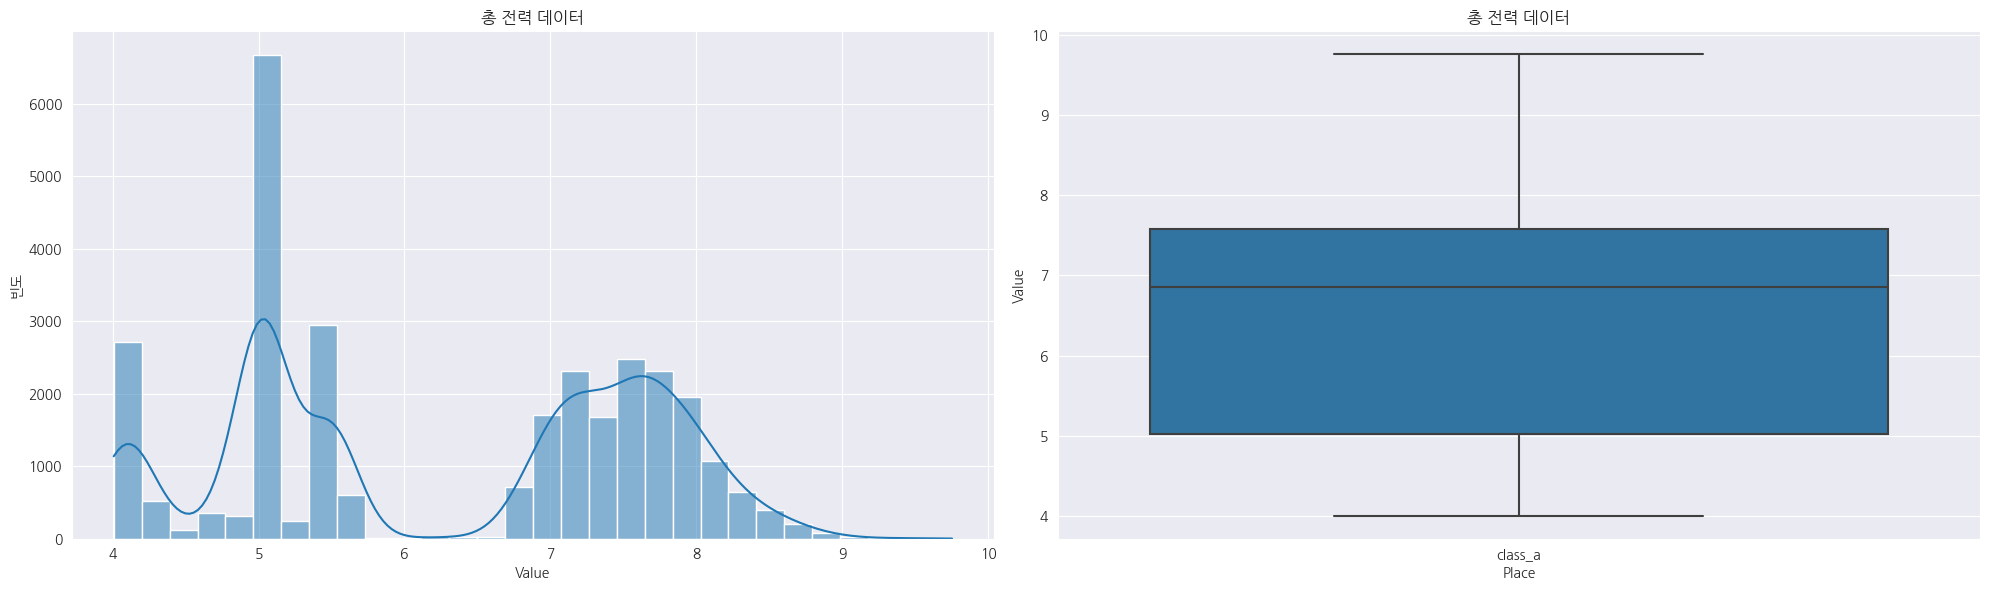

              value
count  30058.000000
mean       6.269482
std        0.358793
min        5.578597
25%        6.046899
50%        6.248043
75%        6.628306
max        6.770101


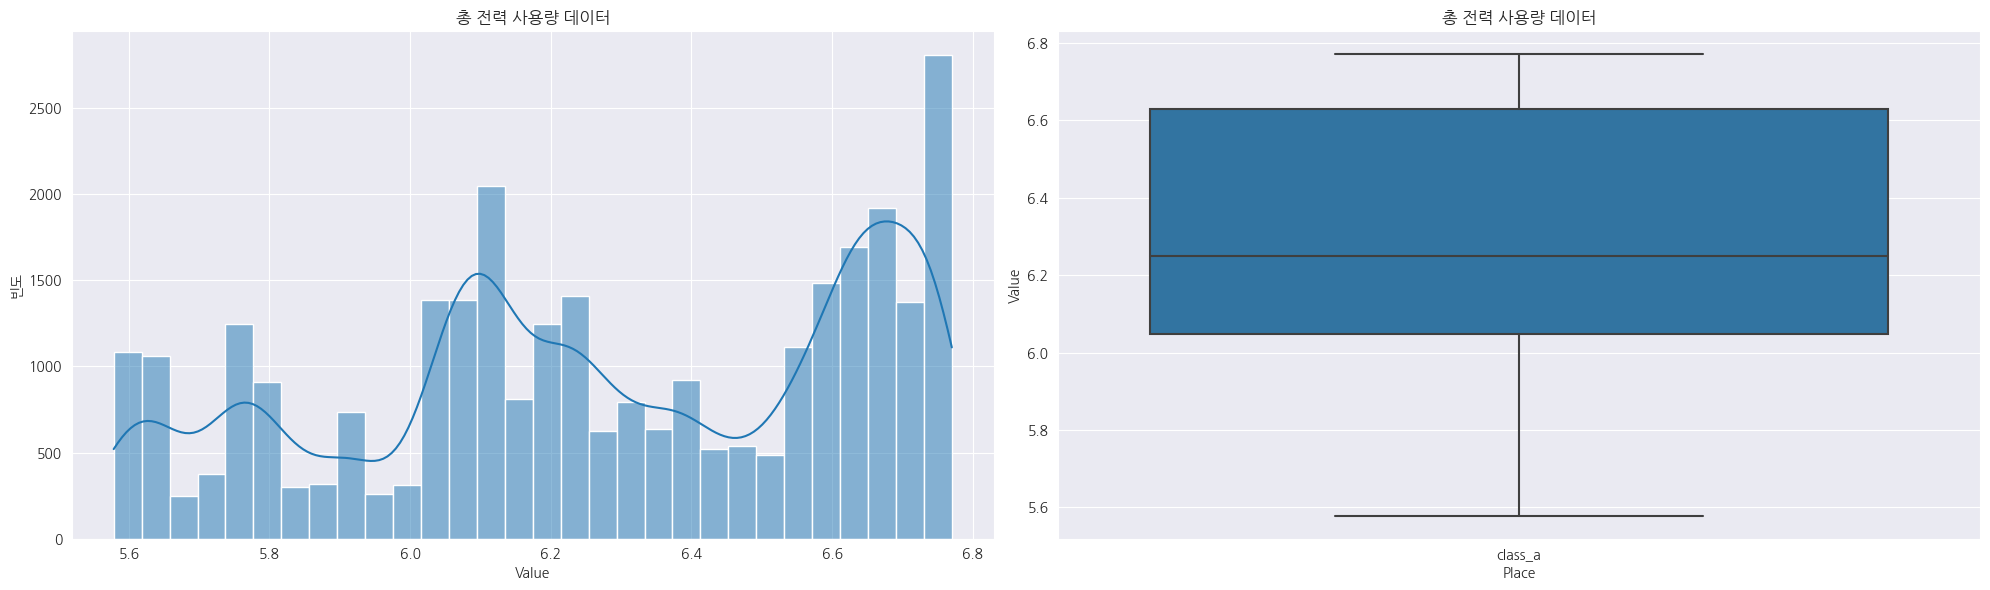

              value
count  30144.000000
mean       3.814146
std        0.665947
min        3.044522
25%        3.178054
50%        3.637586
75%        4.394449
max        5.771441


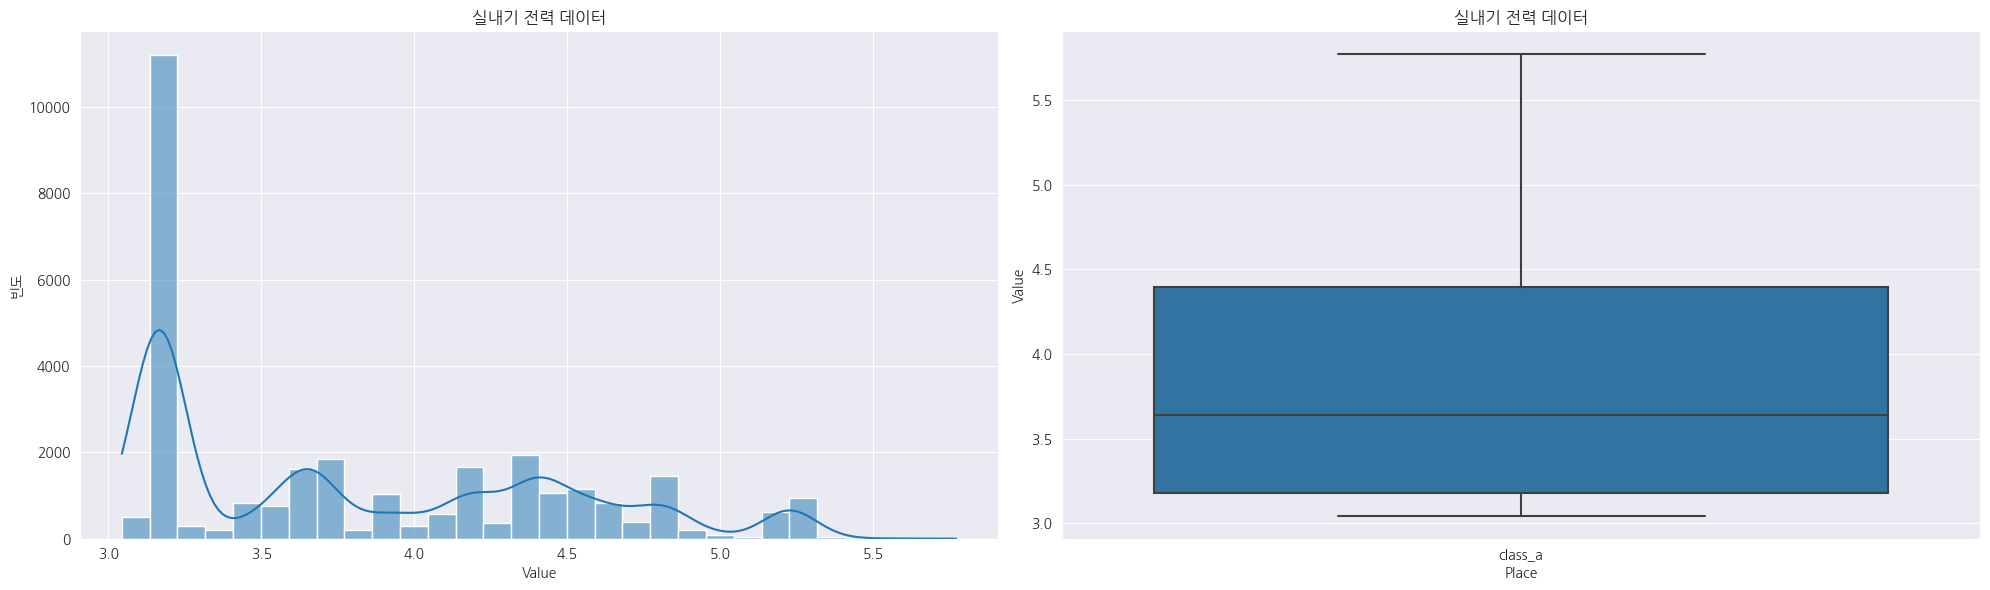

              value
count  30059.000000
mean       3.348916
std        0.319764
min        2.778819
25%        3.126761
50%        3.310543
75%        3.676301
max        3.813307


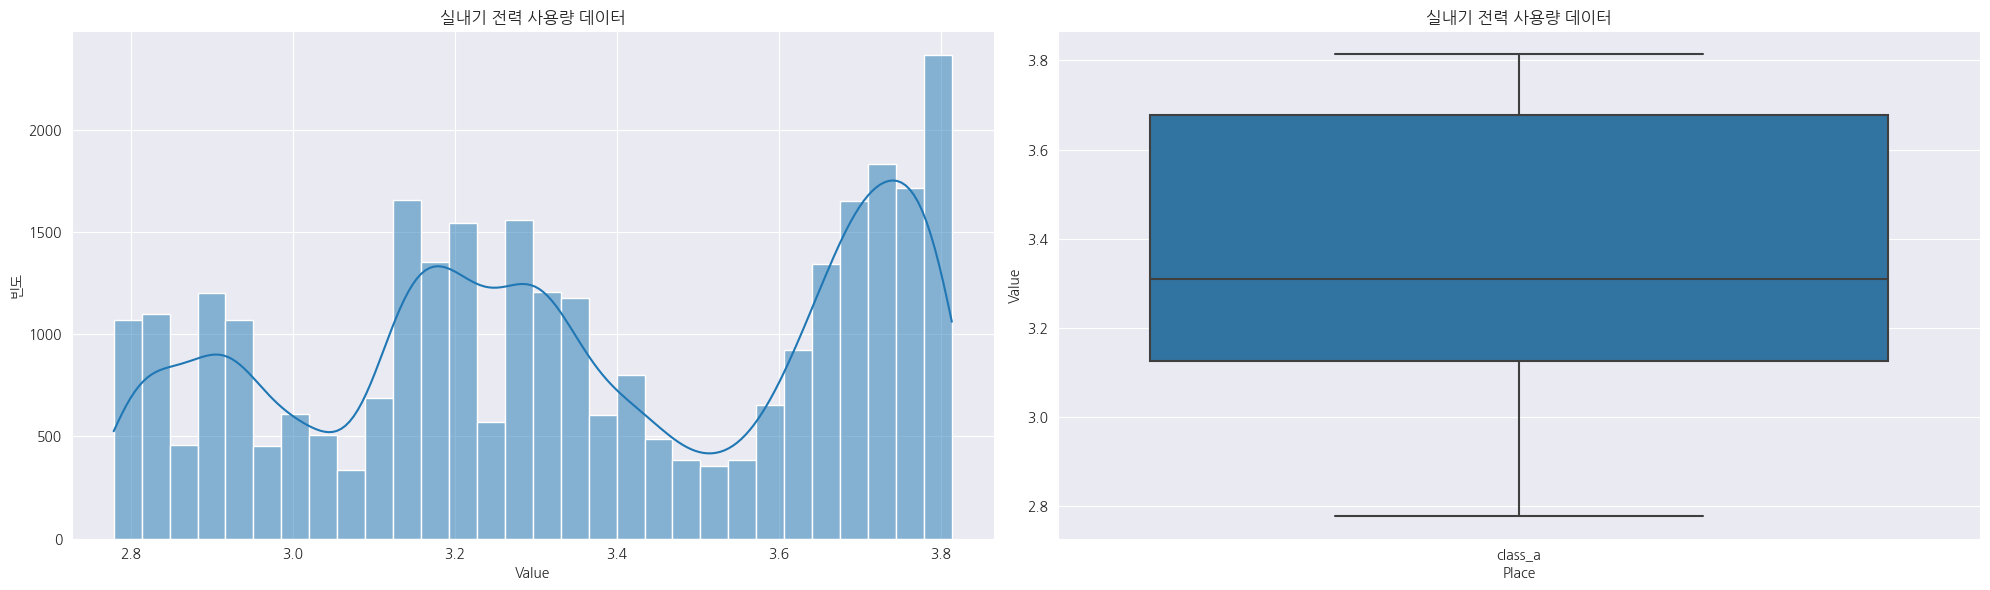

              value
count  30144.000000
mean       6.031975
std        1.685124
min        2.772589
25%        4.744932
50%        6.792905
75%        7.531686
max        9.742027


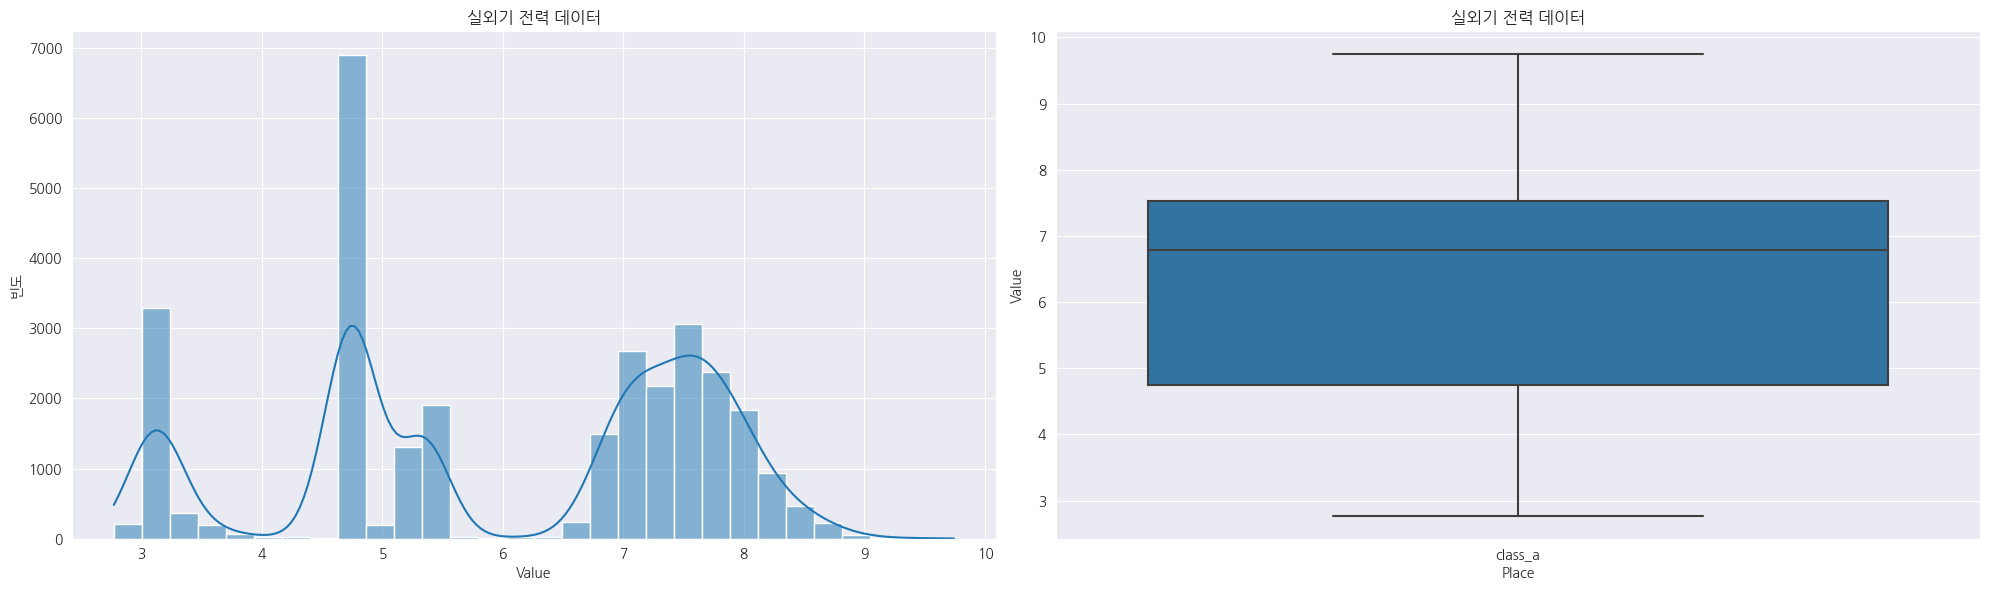

              value
count  30059.000000
mean       6.178370
std        0.370349
min        5.459586
25%        5.952204
50%        6.158038
75%        6.548076
max        6.691711


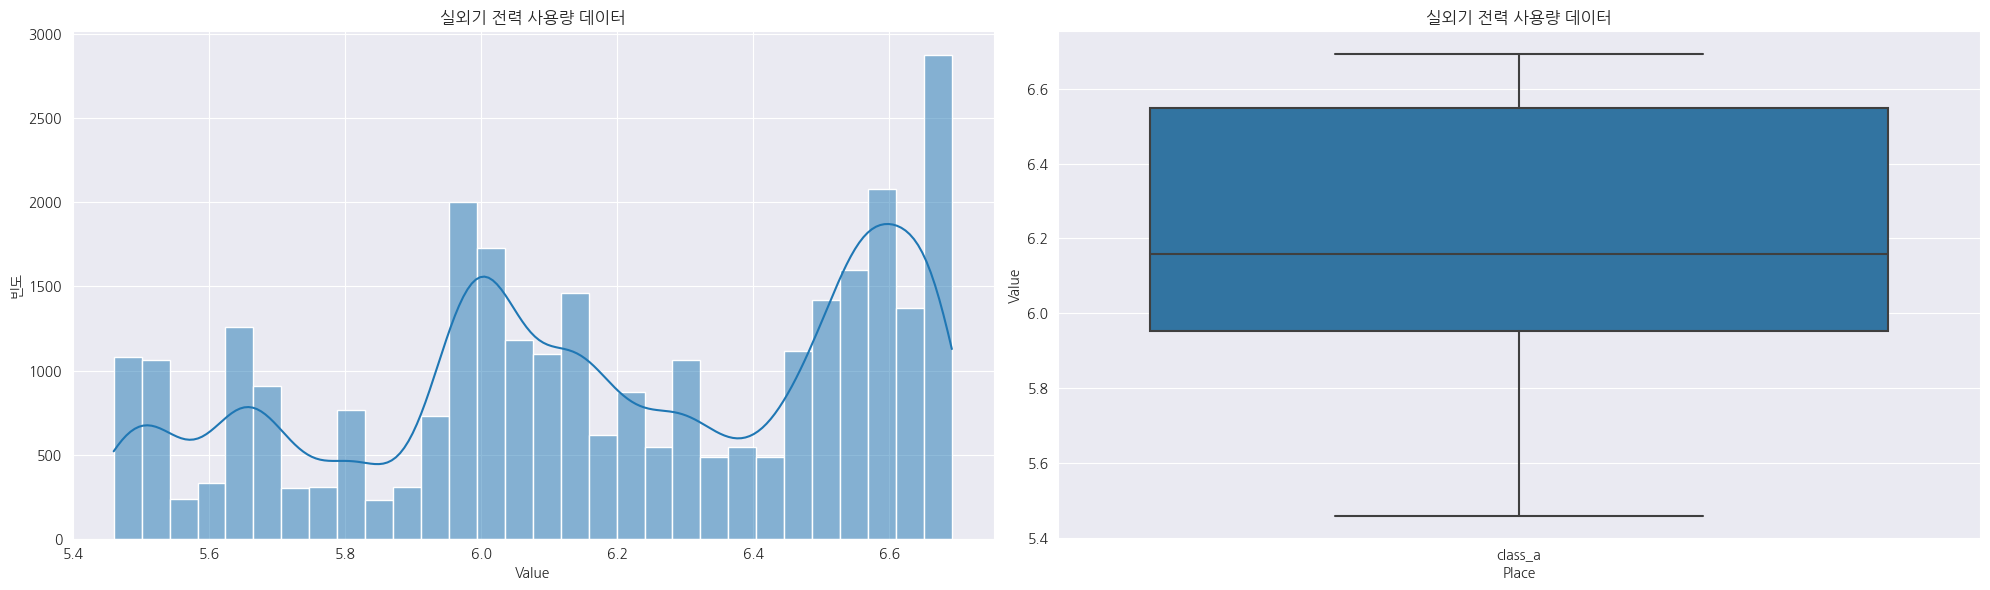

              value
count  30144.000000
mean       2.174606
std        0.222702
min        1.945910
25%        2.197225
50%        2.197225
75%        2.197225
max        3.951244


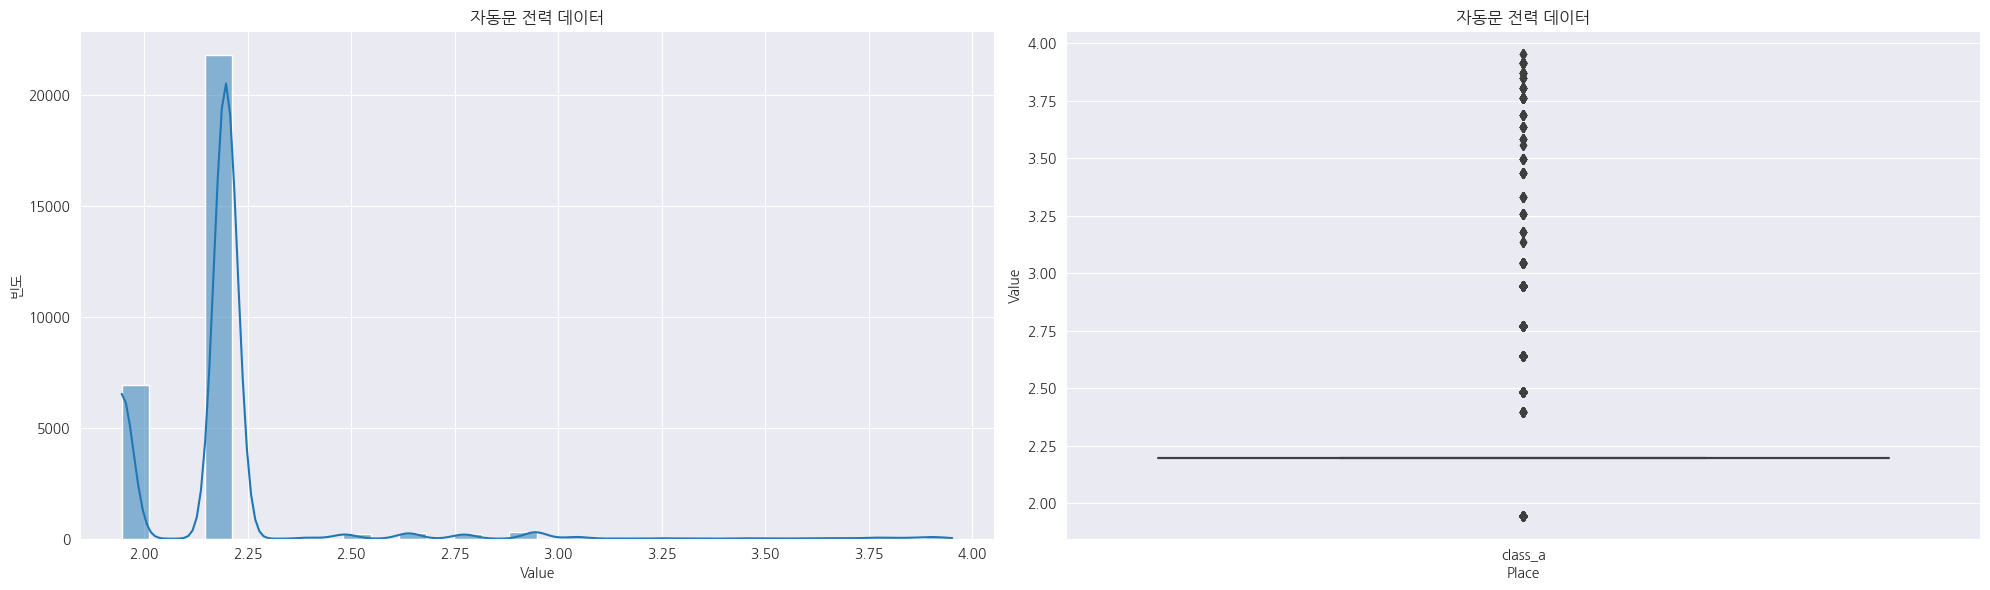

              value
count  30056.000000
mean       2.056395
std        0.180524
min        1.704748
25%        1.902108
50%        2.066863
75%        2.219203
max        2.341806


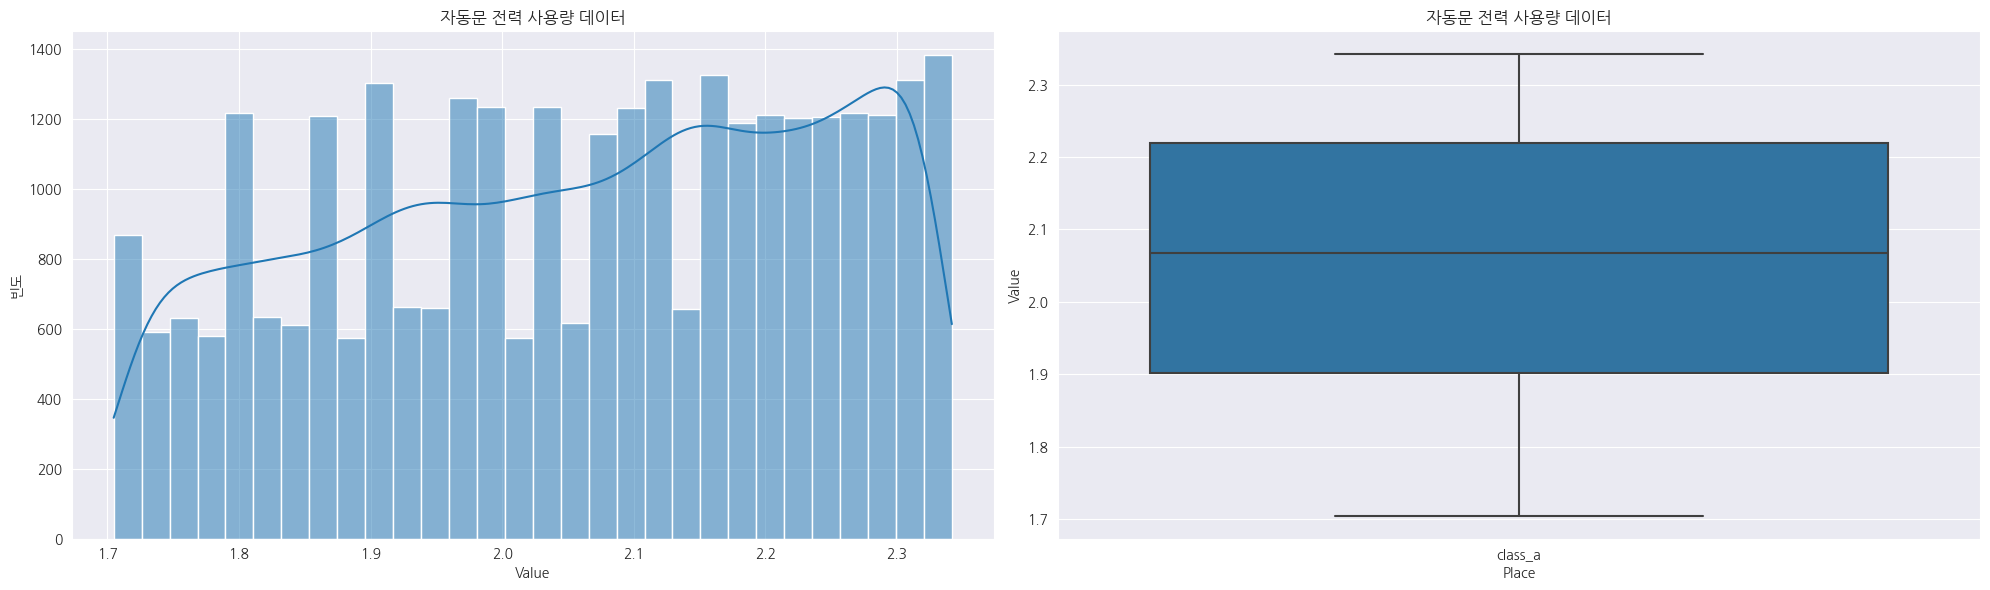

              value
count  30091.000000
mean       4.231094
std        1.166144
min        2.705823
25%        3.111288
50%        3.939267
75%        5.249704
max        6.569551


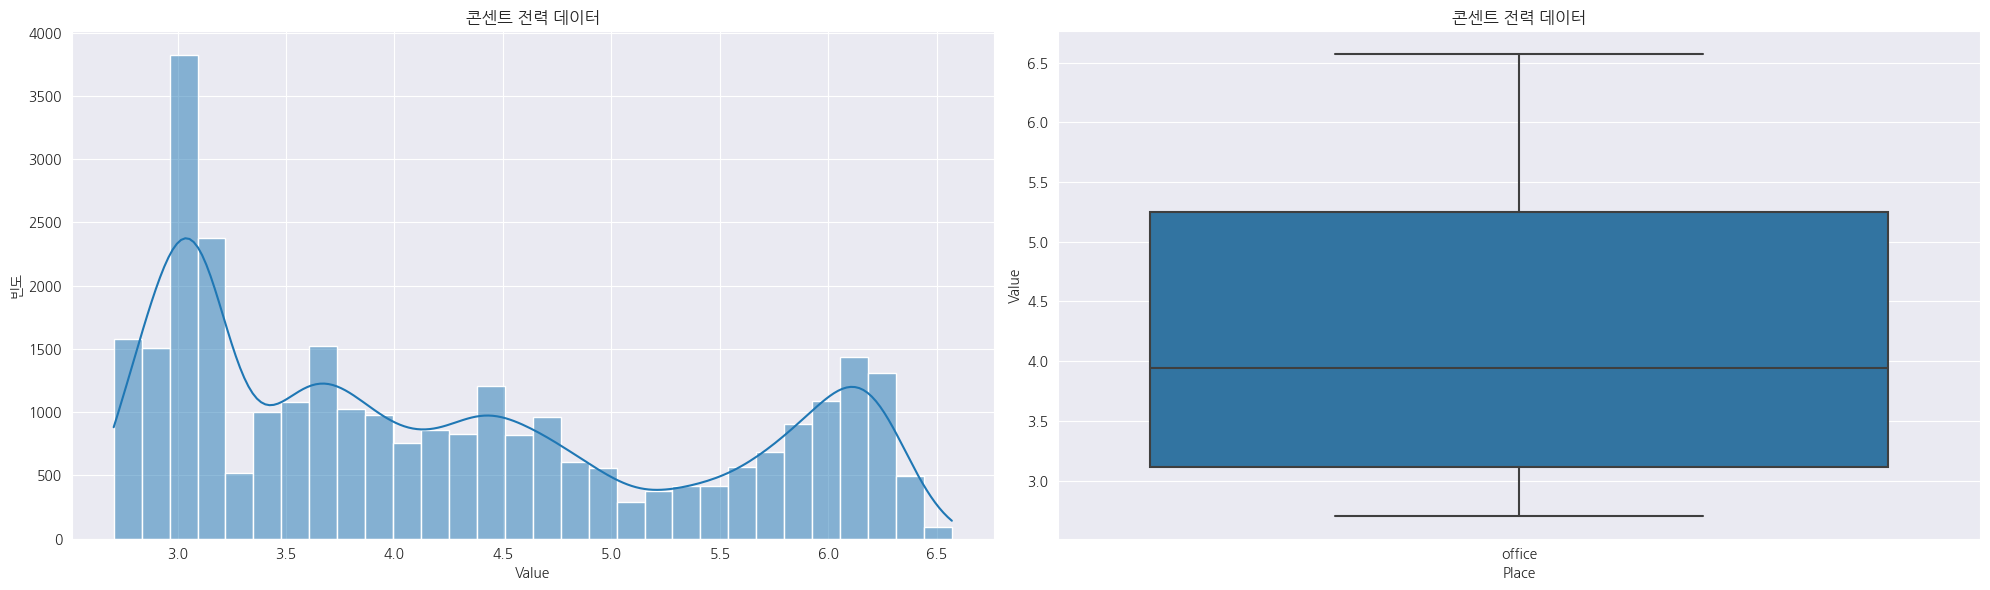

              value
count  29923.000000
mean       4.701209
std        0.196558
min        4.307860
25%        4.563592
50%        4.722647
75%        4.867504
max        4.995415


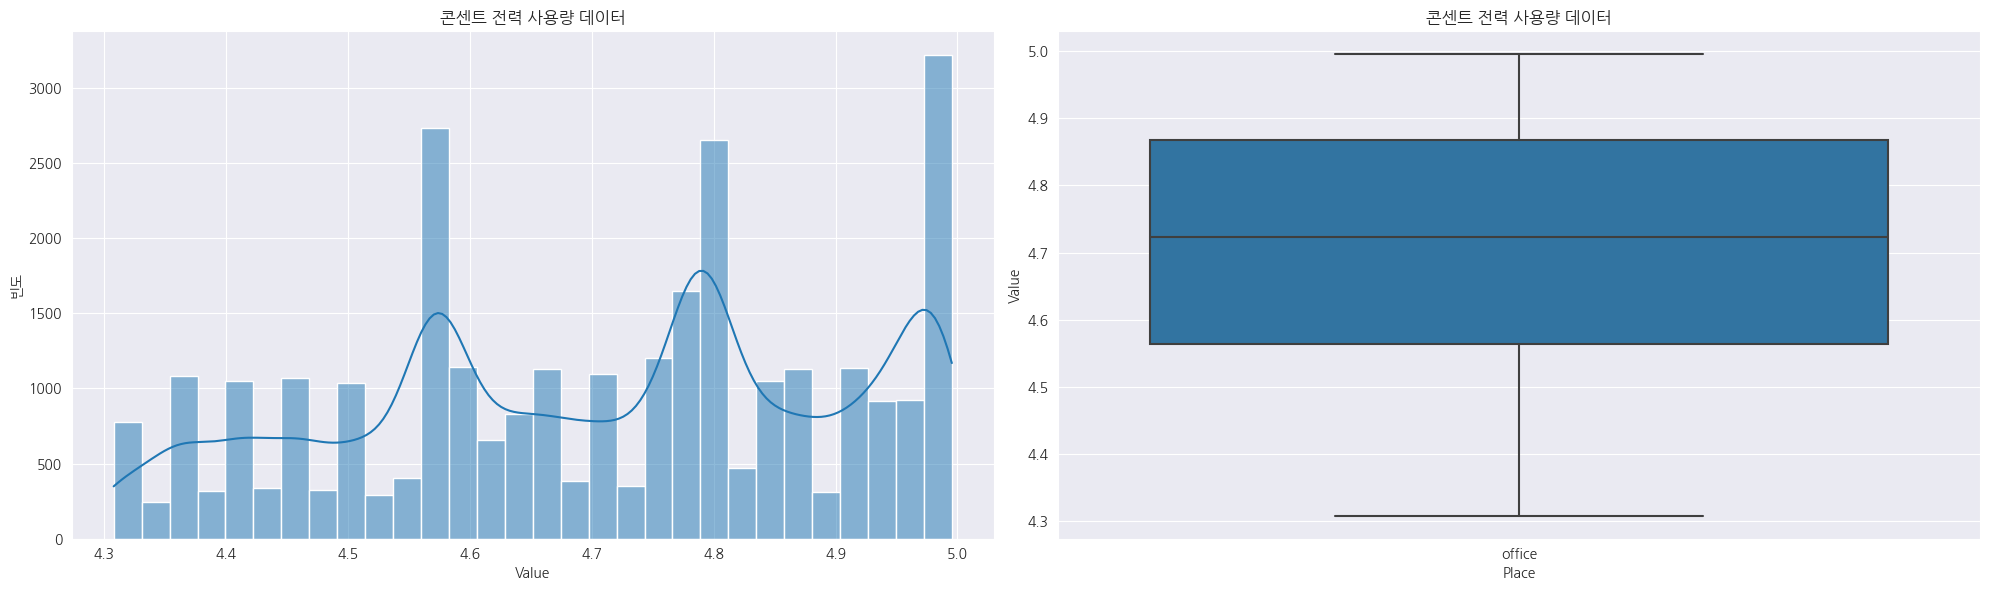

In [44]:
plot(power_total_df, "총 전력 데이터")
plot(power_usage_total_df, "총 전력 사용량 데이터")
plot(power_dataframes['ac_indoor_unit'], "실내기 전력 데이터")
plot(power_usage_dataframes['ac_indoor_unit'], "실내기 전력 사용량 데이터")
plot(power_dataframes['ac_outdoor_unit'], "실외기 전력 데이터")
plot(power_usage_dataframes['ac_outdoor_unit'], "실외기 전력 사용량 데이터")
plot(power_dataframes['automatic_door'], "자동문 전력 데이터")
plot(power_usage_dataframes['automatic_door'], "자동문 전력 사용량 데이터")
plot(power_socket_df, "콘센트 전력 데이터")
plot(power_usage_socket_df, "콘센트 전력 사용량 데이터")

데이터 집계

In [45]:
# 전체 전력/전력량
power_total_df = df_hourly_calculate(power_total_df, "total_power(Wh)", "sum")
power_usage_total_df = df_hourly_calculate(power_usage_total_df, 'total_power_usage(Kwh)', 'diff')

# 실내기 전력 / 전력량
power_ac_in_df = df_hourly_calculate(power_dataframes['ac_indoor_unit'], "ac_in_power(Wh)", "sum")
power_usage_ac_in_df = df_hourly_calculate(power_usage_dataframes['ac_indoor_unit'], "ac_in_power(Kwh)", "diff")

# 실외기 전력/전력량
power_ac_out_df = df_hourly_calculate(power_dataframes['ac_outdoor_unit'], "ac_out_power(Wh)", "sum")
power_usage_ac_out_df = df_hourly_calculate(power_usage_dataframes['ac_outdoor_unit'], "ac_out_power(Kwh)", "diff")

# 자동문 전력/전력량
power_automatic_door_df = df_hourly_calculate(power_dataframes['automatic_door'], "automatic_door_power(Wh)", "sum")
power_usage_automatic_door_df = df_hourly_calculate(power_usage_dataframes['automatic_door'], "automatic_door_power(Kwh)", "diff")

# 콘센트 전력/전력량
power_socket_df = df_hourly_calculate(power_socket_df, "socket_power(Wh)", "sum")
power_usage_socket_df = df_hourly_calculate(power_usage_socket_df, "socket_power(Kwh)", "diff")

데이터 병합 csv

In [46]:
final_main_power_data_df = merge_dataframes([power_total_df])
print(final_main_power_data_df)
final_main_power_data_df = final_main_power_data_df.reset_index()
final_main_power_data_df.to_csv('all_data/all_final_df/class_a_main_power_sensor.csv', index=False)

final_main_power_usage_data_df = merge_dataframes([power_usage_total_df])
print(final_main_power_usage_data_df)
final_main_power_usage_data_df = final_main_power_usage_data_df.reset_index()
final_main_power_usage_data_df.to_csv('all_data/all_final_df/class_a_main_power_usage_sensor.csv', index=False)

final_device_power_data_df = merge_dataframes([power_ac_in_df, power_ac_out_df, power_automatic_door_df, power_socket_df])
print(final_device_power_data_df)
final_power_data_df = final_device_power_data_df.reset_index()
final_power_data_df.to_csv('all_data/all_final_df/class_a_device_power_sensor.csv', index=False)

final_device_power_usage_df = merge_dataframes([power_usage_ac_in_df, power_usage_ac_out_df, power_usage_automatic_door_df, power_usage_socket_df])
print(final_device_power_usage_df)
final_power_usage_df = final_device_power_usage_df.reset_index()
final_power_usage_df.to_csv('all_data/all_final_df/class_a_device_power_usage_sensor.csv', index=False)

                     total_power(Wh)
time                                
2024-04-15 00:00:00          252.368
2024-04-15 01:00:00          318.311
2024-04-15 02:00:00          308.599
2024-04-15 03:00:00          278.989
2024-04-15 04:00:00          316.708
...                              ...
2024-05-05 20:00:00          460.438
2024-05-05 21:00:00          452.240
2024-05-05 22:00:00          453.980
2024-05-05 23:00:00          455.714
2024-05-06 00:00:00            7.231

[505 rows x 1 columns]
time
2024-04-15 00:00:00    0.001
2024-04-15 01:00:00    0.001
2024-04-15 02:00:00    0.001
2024-04-15 03:00:00    0.000
2024-04-15 04:00:00    0.001
                       ...  
2024-05-05 20:00:00    0.003
2024-05-05 21:00:00    0.002
2024-05-05 22:00:00    0.002
2024-05-05 23:00:00    0.002
2024-05-06 00:00:00    0.000
Freq: H, Name: total_power_usage(Kwh), Length: 505, dtype: float64
                     ac_in_power(Wh)  ac_out_power(Wh)  \
time                                          